In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [10]:

def plot_perf_file(filepath, cache_levels, is_vm, df_host = None):
    df = pd.read_csv(filepath, comment='#', header=None, 
                     names=['time', 'counter_value', 'event_name'],
                     usecols=[0, 1, 3])
    cache_df = df[df['event_name'].isin(cache_levels)].copy()
    if cache_df.empty:
        print(f"Empty data for {filepath}")
        return None

    if is_vm:
        walker_hits = df_host[df_host['event_name'].str.startswith('page_walker_loads.dtlb_l')]['counter_value'].sum() + \
                      df_host[df_host['event_name'] == 'page_walker_loads.dtlb_memory:u']['counter_value'].sum()
        miss_causes_walk = df_host[df_host['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u']['counter_value'].sum()
        if type("") in [type(walker_hits), type(miss_causes_walk)]:
            return None
        ratio = max(0, (walker_hits / miss_causes_walk) - 1) if miss_causes_walk != 0 else 0
        time_groups = cache_df.groupby('time')
        for time, group in time_groups:
            mask = (cache_df['time'] == time) & (cache_df['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u')
            cache_df.loc[mask, 'counter_value'] *= (1/2 - ratio/6)

    cache_df.loc[:, 'vm'] = 'With VM' if is_vm else 'Without VM'
    return cache_df

def get_final_df(dir1, dir2, quantities):
    quantities += ['dtlb_load_misses.miss_causes_a_walk:u', 'page_walker_loads.dtlb_l1:u', 'page_walker_loads.dtlb_l2:u', 'page_walker_loads.dtlb_l3:u', 'page_walker_loads.dtlb_memory:u']
    perf_files1 = [os.path.join(dir1, f) for f in os.listdir(dir1) if f.endswith('.perf')]
    perf_files2 = [os.path.join(dir2, f) for f in os.listdir(dir2) if f.endswith('.perf')]

    hosts = {}
    dataframes = []
    for p1 in perf_files1:
        df1 = plot_perf_file(p1, quantities, False)
        if df1 is not None:
            workload = os.path.basename(p1).split('.')[0] 
            df1['workload'] = workload
            hosts[workload] = df1

    for p2 in perf_files2:
        workload = os.path.basename(p2).split('.')[0] 
        if workload in hosts:
            df1 = hosts[workload]
            df2 = plot_perf_file(p2, quantities, True, df1)
            if df2 is not None:
                dataframes.append(df1)
                df2['workload'] = workload
                dataframes.append(df2)
    return pd.concat(dataframes)


Empty data for ./perf_output/out_thp_final/cc-road.1.perf
Empty data for ./perf_output/out_thp_vm_final/pr-road.1.perf


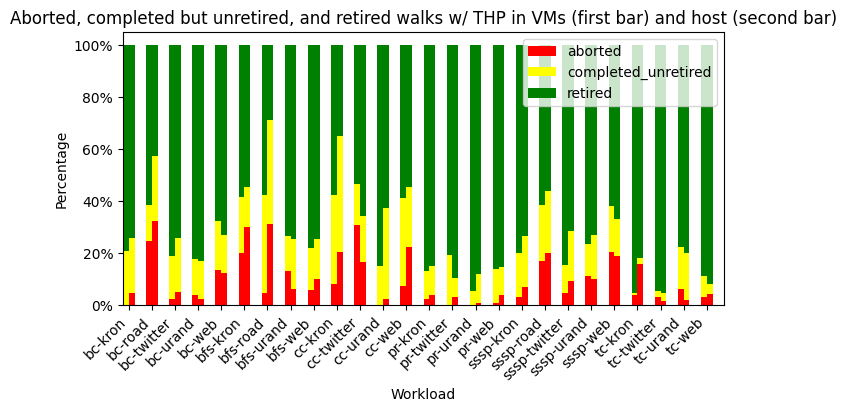

In [11]:
directory_path2 = './perf_output/out_thp_vm_final'  # first bar
directory_path1 = './perf_output/out_thp_final'  # first bar
# directory_path2 = './perf_output/out_vm2'
# directory_path1 = './perf_output/out2'

quantities = ['dtlb_load_misses.miss_causes_a_walk:u', 
            'dtlb_load_misses.walk_completed_4k:u', 
            'dtlb_load_misses.walk_completed_2m_4m:u', 
            'mem_uops_retired.stlb_miss_loads:u']

final_df = get_final_df(directory_path1, directory_path2, quantities)
final_df = final_df[final_df['event_name'] != 'dtlb_load_misses.pde_cache_miss:u']

final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
workloads = final_df.index.get_level_values('workload').unique()
workloads_with_both_vms = []
for workload in workloads:
    if ('With VM' in final_df.loc[workload].index) and ('Without VM' in final_df.loc[workload].index):
        workloads_with_both_vms.append(workload)
df = final_df.loc[workloads_with_both_vms]

final_df = df.copy()
final_df['dtlb_load_misses.miss_causes_a_walk:u'] = (df['dtlb_load_misses.miss_causes_a_walk:u']-df['dtlb_load_misses.walk_completed_4k:u'] - df['dtlb_load_misses.walk_completed_2m_4m:u'])
final_df['dtlb_load_misses.walk_completed_4k:u'] = (df['dtlb_load_misses.walk_completed_4k:u']+df['dtlb_load_misses.walk_completed_2m_4m:u']-df['mem_uops_retired.stlb_miss_loads:u']) 
final_df['mem_uops_retired.stlb_miss_loads:u'] = df['mem_uops_retired.stlb_miss_loads:u'] 
final_df[final_df < 0] = 0
total = final_df[['mem_uops_retired.stlb_miss_loads:u', 'dtlb_load_misses.walk_completed_4k:u', 'dtlb_load_misses.miss_causes_a_walk:u']].sum(axis=1)
final_df['mem_uops_retired.stlb_miss_loads:u'] /= total.replace(0, 1)
final_df['dtlb_load_misses.walk_completed_4k:u'] /= total.replace(0, 1)
final_df['dtlb_load_misses.miss_causes_a_walk:u'] /= total.replace(0, 1)


final_df = final_df.rename(columns={'dtlb_load_misses.miss_causes_a_walk:u': 'aborted', 'dtlb_load_misses.walk_completed_4k:u': 'completed_unretired', 'mem_uops_retired.stlb_miss_loads:u': 'retired'})
expected_columns = ['aborted', 'completed_unretired', 'retired']
final_df = final_df[expected_columns]


ax = final_df.plot(kind='bar', stacked=True, figsize=(7, 4), color=['red', 'yellow', 'green'])
plt.ylabel('Percentage')
plt.xlabel('Workload')
plt.xticks(range(0, len(workloads_with_both_vms)*2, 2), workloads_with_both_vms, rotation=45, ha='right')
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.legend()

# Remove spacing between every other bar
for i, patch in enumerate(ax.patches):
    if i % 2 == 1:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.75)
    if i % 2 == 0:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.25)

plt.title("Aborted, completed but unretired, and retired walks w/ THP in VMs (first bar) and host (second bar)")
plt.show()

Processing file 5/30: /home/andrewm/store/gapbs/benchmark/out_thp/bc-road.1.perf, /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/bc-road.1.perf
Processing file 10/30: /home/andrewm/store/gapbs/benchmark/out_thp/cc-urand.1.perf, /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/cc-urand.1.perf
Processing file 15/30: /home/andrewm/store/gapbs/benchmark/out_thp/cc-web.1.perf, /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/cc-web.1.perf
Empty data for /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/tc-road.1.perf
Processing file 20/30: /home/andrewm/store/gapbs/benchmark/out_thp/pr-twitter.1.perf, /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/tc-web.1.perf
Empty data for /home/andrewm/store/gapbs/benchmark/out_thp/cc-road.1.perf
Empty data for /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/cc-road.1.perf
Processing file 25/30: /home/andrewm/store/gapbs/benchmark/out_thp/pr-road.1.perf, /home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/bc-kr

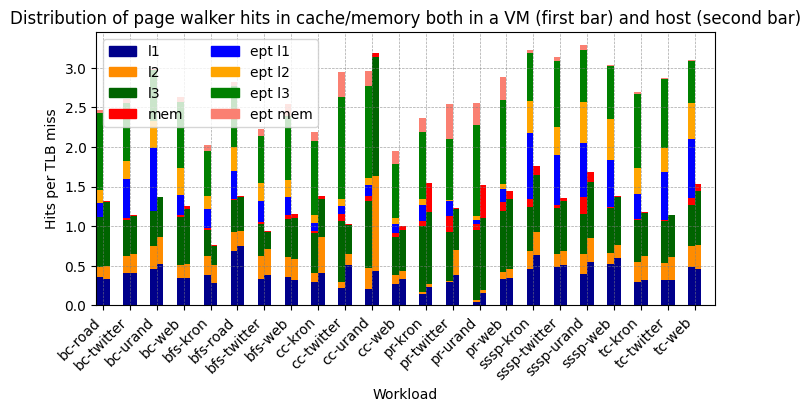

In [13]:
import numpy as np
def plot_perf_file(filepath, cache_levels, is_vm):
    df = pd.read_csv(filepath, comment='#', header=None, 
                     names=['time', 'counter_value', 'event_name'],
                     usecols=[0, 1, 3])
    cache_df = df[df['event_name'].isin(cache_levels)].copy()
    
    if cache_df.empty:
        print(f"Empty data for {filepath}")
        return None
    
    total_dtlb_misses = df[df['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u']['counter_value'].sum()
    if type(total_dtlb_misses) == type(np.int64(0)):
        total_dtlb_misses = df[df['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u']['counter_value'].sum() / (2 if is_vm else 1)
        cache_df.loc[:, 'counter_value'] = cache_df['counter_value'] / total_dtlb_misses
    cache_df.loc[:, 'vm'] = 'With VM' if is_vm else 'Without VM'
    return cache_df

directory_path1 = '/home/andrewm/store/gapbs/benchmark/out_thp'
directory_path2 = '/home/andrewm/store/gapbs/benchmark/out_thp_vm_final'
directory_path2 = '/home/andrewm/store/gapbs/benchmark/out_thp_vm/out_thp/'
perf_files1 = [os.path.join(directory_path1, f) for f in os.listdir(directory_path1) if f.endswith('.perf')]
perf_files2 = [os.path.join(directory_path2, f) for f in os.listdir(directory_path2) if f.endswith('.perf')]

cache_levels2 = [
    'page_walker_loads.dtlb_l1:u', 
    'page_walker_loads.dtlb_l2:u', 
    'page_walker_loads.dtlb_l3:u', 
    'page_walker_loads.dtlb_memory:u',
    'page_walker_loads.ept_dtlb_l1:u', 
    'page_walker_loads.ept_dtlb_l2:u', 
    'page_walker_loads.ept_dtlb_l3:u', 
    'page_walker_loads.ept_dtlb_memory:u']

dataframes = []
for idx, (perf_file1, perf_file2) in enumerate(zip(perf_files1, perf_files2)):
    if idx % 5 == 4:
        print(f"Processing file {idx + 1}/{len(perf_files1)}: {perf_file1}, {perf_file2}")
    df1 = plot_perf_file(perf_file1, cache_levels2, False)
    df2 = plot_perf_file(perf_file2, cache_levels2, True)
    if df1 is not None and df2 is not None:
        df1['workload'] = os.path.basename(perf_file1).split('.')[0]  # Add workload column
        dataframes.append(df1)
        df2['workload'] = os.path.basename(perf_file2).split('.')[0]  # Add workload column
        dataframes.append(df2)

final_df = pd.concat(dataframes)
final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
workloads = final_df.index.get_level_values('workload').unique()
workloads_with_both_vms = []
for workload in workloads:
    if ('With VM' in final_df.loc[workload].index) and ('Without VM' in final_df.loc[workload].index):
        workloads_with_both_vms.append(workload)

final_df = final_df.loc[workloads_with_both_vms]
final_df = final_df.reindex(columns=cache_levels2)
ax = final_df.plot(kind='bar', stacked=True, figsize=(7, 4), color=['darkblue', 'darkorange', 'darkgreen', 'red', 'blue', 'orange', 'green', 'salmon'])
plt.ylabel('Hits per TLB miss')
plt.xlabel('Workload')
plt.xticks(range(0, len(workloads_with_both_vms)*2, 2), workloads_with_both_vms, rotation=45, ha='right')
plt.tight_layout()
colors =['darkblue', 'darkorange', 'darkgreen', 'red', 'blue', 'orange', 'green', 'salmon']
# Create custom legend handles - select every other color for the legend
legend_colors = [colors[i] for i in range(0, 5)]  # Select every other color
# handles = [plt.Rectangle(0,1,1, color=color) for color in legend_colors]
legend_labels = ["l1", "l2", "l3", "mem"]  # Your custom labels
legend_labels = ["l1", "l2", "l3", "mem", "ept l1", "ept l2", "ept l3", "ept mem"]

# plt.legend(handles, legend_labels)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, legend_labels, ncol=2, loc='upper left')
# Remove spacing between every other bar
for i, patch in enumerate(ax.patches):
    if i % 2 == 1:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.75)
    if i % 2 == 0:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.25)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.title("Distribution of page walker hits in cache/memory both in a VM (first bar) and host (second bar)")
plt.show()



Empty data for ./perf_output/out_vm2/pr-road.1.perf
Empty data for ./perf_output/out_thp_vm/out_thp/pr-road.1.perf
Processing file 5/29: ./perf_output/out_vm2/sssp-twitter.1.perf, ./perf_output/out_thp_vm/out_thp/sssp-twitter.1.perf
Processing file 10/29: ./perf_output/out_vm2/bc-road.1.perf, ./perf_output/out_thp_vm/out_thp/bc-road.1.perf
Processing file 15/29: ./perf_output/out_vm2/cc-twitter.1.perf, ./perf_output/out_thp_vm/out_thp/cc-twitter.1.perf
Processing file 20/29: ./perf_output/out_vm2/pr-kron.1.perf, ./perf_output/out_thp_vm/out_thp/pr-kron.1.perf
Empty data for ./perf_output/out_vm2/tc-road.1.perf
Empty data for ./perf_output/out_thp_vm/out_thp/tc-road.1.perf
Processing file 25/29: ./perf_output/out_vm2/cc-urand.1.perf, ./perf_output/out_thp_vm/out_thp/cc-urand.1.perf
Empty data for ./perf_output/out_vm2/cc-road.1.perf


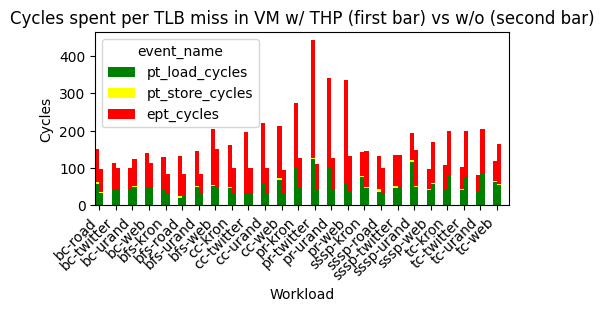

In [14]:
def plot_perf_file(filepath, cache_levels, is_vm):
    df = pd.read_csv(filepath, comment='#', header=None, 
                     names=['time', 'counter_value', 'event_name'],
                     usecols=[0, 1, 3])
    cache_df = df[df['event_name'].isin(cache_levels)].copy()
    if cache_df.empty:
        print(f"Empty data for {filepath}")
        return None
    cache_df.loc[:, 'vm'] = 'With VM' if is_vm else 'Without VM'
    return cache_df

directory_path2 = './perf_output/out_thp_vm/out_thp'
directory_path1 = './perf_output/out2'
directory_path1 = './perf_output/out_vm2'
# directory_path2 = './perf_output/out_thp'

perf_files1 = [os.path.join(directory_path1, f) for f in os.listdir(directory_path1) if f.endswith('.perf')]
perf_files2 = [os.path.join(directory_path2, f) for f in os.listdir(directory_path2) if f.endswith('.perf')]

quantities = ['cycles:u', 
            'dtlb_load_misses.walk_duration:u', 
            'dtlb_store_misses.walk_duration:u',
    'dtlb_load_misses.miss_causes_a_walk:u',
            'ept.walk_cycles:u']

dataframes = []
for idx, (perf_file1, perf_file2) in enumerate(zip(perf_files1, perf_files2)):
    if idx % 5 == 4:
        print(f"Processing file {idx + 1}/{len(perf_files1)}: {perf_file1}, {perf_file2}")
    df1 = plot_perf_file(perf_file1, quantities, False)
    df2 = plot_perf_file(perf_file2, quantities, True)
    if df1 is not None and df2 is not None:
        df1['workload'] = os.path.basename(perf_file1).split('.')[0]  # Add workload column
        dataframes.append(df1)
        df2['workload'] = os.path.basename(perf_file2).split('.')[0]  # Add workload column
        dataframes.append(df2)

final_df = pd.concat(dataframes)
final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
workloads = final_df.index.get_level_values('workload').unique()
workloads_with_both_vms = []
for workload in workloads:
    if ('With VM' in final_df.loc[workload].index) and ('Without VM' in final_df.loc[workload].index):
        workloads_with_both_vms.append(workload)
df = final_df.loc[workloads_with_both_vms]
df.fillna(0, inplace=True)

final_df = df.copy()
load_misses = df['dtlb_load_misses.walk_duration:u']
store_misses = df['dtlb_store_misses.walk_duration:u']
total_misses = load_misses + store_misses
final_df['pt_load_cycles'] = (df['dtlb_load_misses.walk_duration:u'] - df['ept.walk_cycles:u'] * (load_misses / total_misses)) / df['dtlb_load_misses.miss_causes_a_walk:u'] * 2
final_df['pt_store_cycles'] = (df['dtlb_store_misses.walk_duration:u'] - df['ept.walk_cycles:u'] * (store_misses / total_misses)) / df['dtlb_load_misses.miss_causes_a_walk:u'] * 2
final_df['ept_cycles'] = df['ept.walk_cycles:u'] / df['dtlb_load_misses.miss_causes_a_walk:u'] * 2
final_df = final_df[['pt_load_cycles', 'pt_store_cycles', 'ept_cycles']]
# final_df = final_df[['pt_load_cycles', 'pt_store_cycles']]
# ax = final_df.plot(kind='bar', stacked=True, figsize=(20, 10), color=['green', 'yellow', 'red', 'orange'])
ax = final_df.plot(kind='bar', stacked=True, figsize=(5, 3), color=['green', 'yellow', 'red'])

plt.ylabel('Cycles')
plt.xlabel('Workload')
plt.xticks(range(0, len(workloads_with_both_vms)*2, 2), workloads_with_both_vms, rotation=45, ha='right')
plt.tight_layout()

# Remove spacing between every other bar
for i, patch in enumerate(ax.patches):
    if i % 2 == 1:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.75)
    if i % 2 == 0:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.25)

plt.title("Cycles spent per TLB miss in VM w/ THP (first bar) vs w/o (second bar)")
plt.show()


In [9]:
def read_perf_data(filepath, events):
    try:
        df = pd.read_csv(filepath, comment='#', header=None, 
                        names=['time', 'counter_value', 'event_name'],
                        usecols=[0, 1, 3])
        df['counter_value'] = pd.to_numeric(df['counter_value'], errors='coerce')  # Convert to numeric, make errors NaN
        df.dropna(subset=['counter_value'], inplace=True)  # Drop rows with NaN counter values
        return df[df['event_name'].isin(events)]
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

# Paths to the directories containing the .perf files
directory_paths = {
    'without_thp_host': './perf_output/out',
    'without_thp_vm':  './perf_output/out_vm2',
    'with_thp_host': './perf_output/out_thp',
    'with_thp_vm':  './perf_output/out_thp_vm/out_thp'
}
# directory_path2 = '/home/andrewm/store/gapbs/benchmark/out_thp'
# Relevant events
events = [
    'dtlb_load_misses.walk_duration:u',
    'dtlb_load_misses.miss_causes_a_walk:u',
    'ept.walk_cycles:u'
]
# Data structure to hold the sums
sums = {
    'without_thp_host': {'dtlb_miss_causes_a_walk': 0, 'walk_duration': 0, 'count': 0},
    'without_thp_vm': {'dtlb_miss_causes_a_walk': 0, 'walk_duration': 0, 'count': 0},
    'with_thp_host': {'dtlb_miss_causes_a_walk': 0, 'walk_duration': 0, 'count': 0},
    'with_thp_vm': {'dtlb_miss_causes_a_walk': 0, 'walk_duration': 0, 'count': 0}
}

# Process the files
for condition, path in directory_paths.items():
    perf_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.perf')]
    
    for perf_file in perf_files:
        df = read_perf_data(perf_file, events)
        
        if not df.empty:
            walk_durations = df[df['event_name'] == 'dtlb_load_misses.walk_duration:u']['counter_value'].sum() + df[df['event_name'] == 'ept.walk_cycles:u']['counter_value'].sum()
            dtlb_misses = df[df['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u']['counter_value'].sum()
            
            sums[condition]['walk_duration'] += walk_durations
            sums[condition]['dtlb_miss_causes_a_walk'] += dtlb_misses / (2 if "vm" in condition else 1)
            sums[condition]['count'] += 1

averages = {}
for condition, values in sums.items():
    averages[condition] = {
        'average_dtlb_miss_causes_a_walk': values['dtlb_miss_causes_a_walk'] / values['count'],
        'average_walk_duration': values['walk_duration'] /values['count'],
    }

# Convert to DataFrame for display
average_df = pd.DataFrame(averages).T
average_df

,average_dtlb_miss_causes_a_walk,average_walk_duration
without_thp_host,1.044765e+11,5.916856e+12
without_thp_vm,1.411854e+11,2.906319e+13
with_thp_host,2.921811e+10,1.268174e+12
with_thp_vm,9.351064e+09,1.729541e+12
